<a href="https://colab.research.google.com/github/Lukas-Pupelis/Kursinis/blob/main/Kursinis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import cv2 as cv
import torch
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import tensorflow as tf
import pandas as pd
import torch.nn.functional as F
from tensorflow.keras import backend as K
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, jaccard_score
from scipy.stats import ttest_rel
from torch.utils.data import Dataset, DataLoader
!pip install pretrainedmodels
!pip install efficientnet_pytorch

In [ ]:
from google.colab import drive
drive_dir = drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_dir = '/content/drive/My Drive/mp'
weight_dir = '/content/drive/My Drive/clam_weights/pre-trained_weights'
model_dir = '/content/drive/My Drive/MP-Net/src/segmentation_models/segmentation_models_pytorch'
root_dir = "/content/drive/My Drive/MP-Net/src/segmentation_models"
images_dir = os.path.join(data_dir, 'images')
masks_dir = os.path.join(data_dir, 'masks')
unet_dir = os.path.join(model_dir, 'unet')
resized_images_dir = os.path.join(data_dir, 'resized_images')
resized_masks_dir = os.path.join(data_dir, 'resized_masks')
inverted_resized_masks_dir = os.path.join(data_dir, 'inverted_resized_masks')

# Unet

In [ ]:
import sys
from importlib import import_module

def create_model():

  if root_dir not in sys.path:
      sys.path.append(root_dir)

  # 3. Check existence
  if not os.path.isdir(unet_dir):
      print(f"Error: The 'unet' directory was not found at '{unet_dir}'.")
      sys.exit(1)

  # from segmentation_models_pytorch.unet.model import Unet

  # Dynamically import the UNet class from unet.model
  try:
      unet_model = import_module('segmentation_models_pytorch.unet.model')
      UNet = getattr(unet_model, 'Unet')  # or 'UNet' if spelled that way
  except ModuleNotFoundError as e:
      print(f"Error importing the Unet model: {e}")
      sys.exit(1)
  except AttributeError:
      print("Error: The 'Unet' class was not found in 'model.py'.")
      sys.exit(1)

  model = UNet(encoder_name="resnet101",
      encoder_weights=None,
      in_channels=3,
      classes=1)

  model.load_state_dict(
      torch.load(os.path.join(weight_dir, 'unet4.pth'), map_location='cpu'),
      )

  model.eval()

  return model

# Resizing and saving to Drive

In [ ]:
for dir in [images_dir, masks_dir]:
  for i, img_name in enumerate(os.listdir(dir)):
    image_path = os.path.join(dir, img_name)
    img = cv.imread(image_path)
    resized_img = cv.resize(img, (256, 256), interpolation=cv.INTER_AREA)

    cv.imwrite(os.path.join(resized_images_dir if "images" in dir else resized_masks_dir, img_name), resized_img)

KeyboardInterrupt: 

# Loading

In [ ]:
class SegmentationDatasetRGB(Dataset):
    """
    A dataset that reads RGB images and RGB masks, then:
      - Converts the mask to grayscale.
      - Optionally inverts the mask (255 -> 0, 0 -> 255) if needed.
      - Binarizes the mask into 0/1.
      - Returns PyTorch tensors of shape:
         image: (3, H, W)
         mask:  (1, H, W)
    """
    def __init__(
        self,
        images_dir,
        masks_dir,
        invert_mask,    # If True, flips 0<->255 after converting to grayscale
        transform=None        # Optional data augmentation (Albumentations, etc.)
    ):
        super().__init__()
        self.images_dir = images_dir
        self.masks_dir  = masks_dir
        self.invert_mask = invert_mask
        self.transform = transform

        # Collect the filenames (assumes same filenames exist in images_dir and masks_dir)
        self.image_names = sorted(os.listdir(images_dir))

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_name = self.image_names[idx]
        image_path = os.path.join(self.images_dir, img_name)
        mask_path  = os.path.join(self.masks_dir,  img_name)

        # 1) Read the image in BGR
        img_bgr = cv.imread(image_path, cv.IMREAD_COLOR)
        #if img_bgr is None:
            #raise ValueError(f"Could not read image at {image_path}")

        # 2) Convert BGR -> RGB
        img_rgb = cv.cvtColor(img_bgr, cv.COLOR_BGR2RGB)

        # 3) Read the mask in BGR, convert to RGB
        mask_bgr = cv.imread(mask_path, cv.IMREAD_COLOR)
        #if mask_bgr is None:
            #raise ValueError(f"Could not read mask at {mask_path}")
        mask_rgb = cv.cvtColor(mask_bgr, cv.COLOR_BGR2RGB)

        # 4) Convert mask from RGB -> Grayscale
        mask_gray = cv.cvtColor(mask_rgb, cv.COLOR_RGB2GRAY)  # shape (H, W), values [0..255]

        # 5) Optionally invert the mask if the foreground/background is reversed
        if self.invert_mask:
            mask_gray = 255 - mask_gray  # flips 0<->255

        # 6) Binarize.
        mask_bin = (mask_gray == 0).astype(np.uint8)

        # 7) Optional Albumentations transform
        if self.transform:
            augmented = self.transform(image=img_rgb, mask=mask_bin)
            img_rgb   = augmented["image"]
            mask_bin  = augmented["mask"]

        # 8) Convert to PyTorch tensors
        #    (H, W, 3) -> (3, H, W)
        if isinstance(img_rgb, np.ndarray):
            img_rgb = torch.tensor(img_rgb, dtype=torch.float32).permute(2, 0, 1)
        #    (H, W) -> (1, H, W)
        if isinstance(mask_bin, np.ndarray):
            mask_bin = np.expand_dims(mask_bin, axis=0)  # (1, H, W)
            mask_bin = torch.tensor(mask_bin, dtype=torch.float32)

        return img_rgb, mask_bin

In [ ]:
def get_dataloader(images_dir, masks_dir, invert_mask, batch_size=32):
    dataset = SegmentationDatasetRGB(
        images_dir=images_dir,
        masks_dir=masks_dir,
        invert_mask=invert_mask,
        transform=None
    )
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

# Statistics

In [ ]:
def calculate_metrics(y_true, y_pred, threshold=0.5):

    # Squeeze channels if needed
    if y_true.ndim == 3 and y_true.shape[0] == 1:
        y_true = y_true[0]  # -> (H, W)
    if y_pred.ndim == 3 and y_pred.shape[0] == 1:
        y_pred = y_pred[0]  # -> (H, W)

    # Binarize the prediction
    y_pred_bin = (y_pred > threshold).astype(np.uint8)

    # Flatten
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred_bin.flatten()

    # Compute metrics
    accuracy  = accuracy_score(y_true_flat, y_pred_flat)
    precision = precision_score(y_true_flat, y_pred_flat, average="binary", zero_division=1)
    recall    = recall_score(y_true_flat, y_pred_flat, average="binary", zero_division=1)
    f1        = f1_score(y_true_flat, y_pred_flat, average="binary", zero_division=1)
    iou       = jaccard_score(y_true_flat, y_pred_flat, average="binary", zero_division=1)

    return accuracy, precision, recall, f1, iou

In [ ]:
def test_model_and_calculate_statistics(model, dataloader, device="cpu", threshold=0.5):

    model.eval()
    model.to(device)

    metrics_dict = {
        "accuracy":  [],
        "precision": [],
        "recall":    [],
        "f1":        [],
        "iou":       []
    }

    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            outputs = model(images)               # shape (B,1,H,W)
            preds   = torch.sigmoid(outputs).cpu().numpy()  # -> [0..1] float
            masks   = masks.cpu().numpy()         # shape (B,1,H,W)

            # Per-sample metric calculation
            for i in range(len(masks)):
                acc, prec, rec, f1, iou = calculate_metrics(
                    y_true=masks[i],
                    y_pred=preds[i],
                    threshold=threshold
                )
                metrics_dict["accuracy"].append(acc)
                metrics_dict["precision"].append(prec)
                metrics_dict["recall"].append(rec)
                metrics_dict["f1"].append(f1)
                metrics_dict["iou"].append(iou)

    # Compute mean across the dataset
    mean_metrics = {k: float(np.mean(v)) for k, v in metrics_dict.items()}
    return mean_metrics

# Visualizing

In [ ]:
def visualize_prediction(img_tensor, mask_tensor, pred_tensor, threshold=0.5):

    # Convert to NumPy
    img_np  = img_tensor.detach().cpu().numpy()
    mask_np = mask_tensor.detach().cpu().numpy()
    pred_np = pred_tensor.detach().cpu().numpy()

    # Squeeze dims if needed
    if img_np.ndim == 3 and img_np.shape[0] == 3:
        # (3,H,W) -> (H,W,3)
        img_np = np.transpose(img_np, (1,2,0))
    if mask_np.ndim == 3 and mask_np.shape[0] == 1:
        mask_np = mask_np[0]
    if pred_np.ndim == 3 and pred_np.shape[0] == 1:
        pred_np = pred_np[0]

    # Binarize predictions
    pred_bin = (pred_np > threshold).astype(np.uint8)

    # If image is in [0..255], scale to [0..1] for display
    if img_np.max() > 1:
        img_display = img_np / 255.0
    else:
        img_display = img_np

    fig, axes = plt.subplots(1, 3, figsize=(15,5))
    axes[0].imshow(img_display)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    axes[1].imshow(mask_np, cmap="gray", vmin=0, vmax=1)
    axes[1].set_title("Ground-Truth Mask")
    axes[1].axis("off")

    axes[2].imshow(pred_bin, cmap="gray", vmin=0, vmax=1)
    axes[2].set_title("Predicted Mask")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()


def visualize_batch(model, dataloader, device="cpu", threshold=0.5):
    """
    Pulls one batch from the dataloader, displays the first sample
    (image, ground-truth mask, predicted mask).
    """
    model.eval()
    model.to(device)

    images, masks = next(iter(dataloader))
    images = images.to(device)

    with torch.no_grad():
        outputs = model(images)
        preds   = torch.sigmoid(outputs).cpu().numpy()  # shape (B,1,H,W)

    # Let's just visualize idx=0
    idx = 0
    img_tensor  = images[idx].cpu()   # (3,H,W)
    mask_tensor = masks[idx].cpu()    # (1,H,W)
    pred_tensor = torch.from_numpy(preds[idx])  # (1,H,W) as a torch tensor

    visualize_prediction(img_tensor, mask_tensor, pred_tensor, threshold=threshold)

# Executing and table creating

<ipython-input-20-16cce2385dad>:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(weight_dir, 'unet4.pth'), map_location='cpu'),


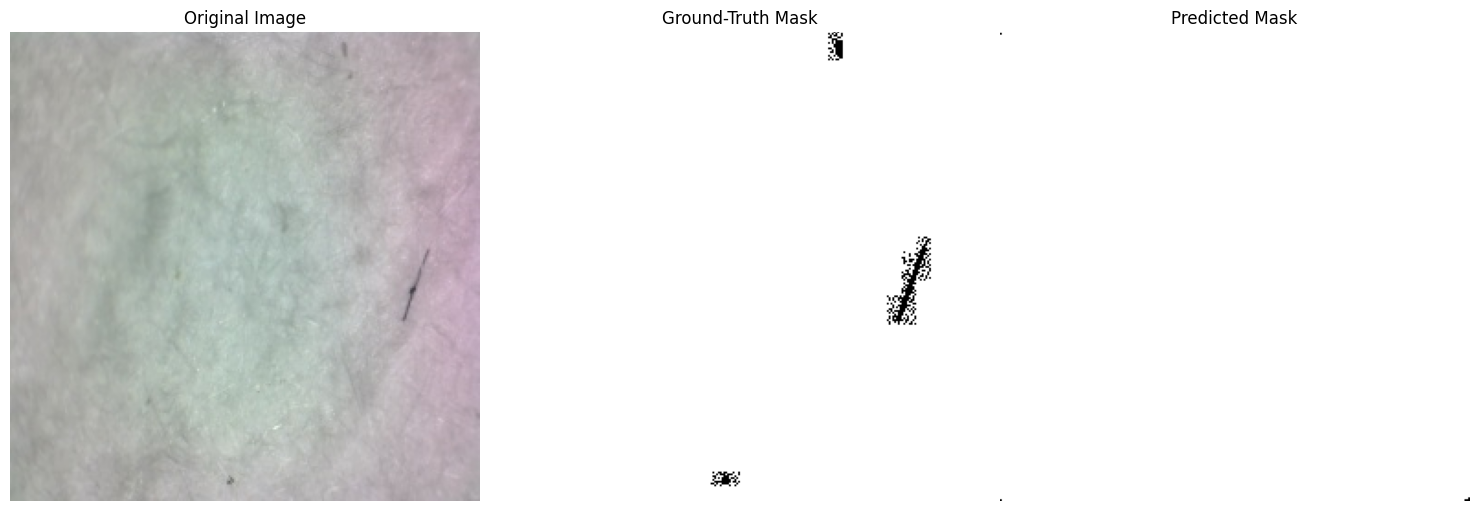

KeyboardInterrupt: 

In [ ]:
def main():
    # You must provide the paths to your images and masks.
    # Each must have matching filenames (e.g. "001.png" for both).
    images_dir = resized_images_dir
    masks_dir  = resized_masks_dir

    # If your model was trained on black=foreground, white=background,
    # but your masks are the opposite, set invert_mask=True.
    # Otherwise, set invert_mask=False.
    invert_mask = False

    # 1) Create the Dataloader
    dataloader = get_dataloader(
        images_dir=images_dir,
        masks_dir=masks_dir,
        invert_mask=invert_mask,
        batch_size=32
    )

    # 2) Create or load your model
    model = create_model()
    # If you have pretrained weights, load them:
    #   model.load_state_dict(torch.load("model_weights.pth"))

    # 3) Visualize a sample batch
    #    (Helps you confirm if the mask is indeed correct after inversion/binarization)
    visualize_batch(model, dataloader, device="cpu", threshold=0.5)

    # 4) Calculate metrics on the entire dataset
    metrics = test_model_and_calculate_statistics(
        model=model,
        dataloader=dataloader,
        device="cpu",       # or "cuda"
        threshold=0.5       # threshold for converting probabilities to 0/1
    )

    # 5) Print the results
    print("===== METRICS =====")
    for k,v in metrics.items():
        print(f"{k}: {v:.4f}")


if __name__ == "__main__":
    main()

In [ ]:
import pandas as pd
from tabulate import tabulate  # Optional, for a nice CLI table

def print_metrics_table(metrics_dict):
    """
    Print metrics in a tabular format using pandas DataFrame.
    """
    # Create a DataFrame from the metrics dictionary
    metrics_df = pd.DataFrame([metrics_dict])

    # Print as a table
    print("Metrics Table:")
    print(tabulate(metrics_df, headers="keys", tablefmt="grid"))


# Example Usage in Model Testing
mean_metrics = {
    "Accuracy": 0.9984041124064632,
    "Precision": 0.9985147215265792,
    "Recall": 0.9998888119327677,
    "F1-Score": 0.9991957977679148,
    "IoU": 0.9984040054103518
}

# Call the function to display metrics
print_metrics_table(mean_metrics)